In [1]:
import uproot
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

from utils.file_info import parse

In [2]:
CEPH_DIR = "/ceph/cms/store/user/jguiang/VBSWHSignalGeneration/v2/"
YEAR = "RunIISummer20UL18"
NEG_FILENAME = f"{CEPH_DIR}/VBSWH_negLambdaWZ_kWkZscan_m2to2_Mjj100toInf_TuneCP5_{YEAR}-106X_privateMC_NANOGEN_v2/merged.root"
POS_FILENAME = f"{CEPH_DIR}/VBSWH_posLambdaWZ_kWkZscan_m2to2_Mjj100toInf_TuneCP5_{YEAR}-106X_privateMC_NANOGEN_v2/merged.root"

In [3]:
with open(f"../analysis/data/VBSWH_negLambda_reweights.txt", "r") as f_in:
    neg_reweight_names = f_in.read().splitlines()
    
with open(f"../analysis/data/VBSWH_posLambda_reweights.txt", "r") as f_in:
    pos_reweight_names = f_in.read().splitlines()

with uproot.open(NEG_FILENAME) as f:
    neg_reweights = np.stack(f["Events"].arrays("LHEReweightingWeight", library="np")["LHEReweightingWeight"])
    neg_reweights = np.insert(neg_reweights, 139, 1, axis=1)
    
with uproot.open(POS_FILENAME) as f:
    pos_reweights = np.stack(f["Events"].arrays("LHEReweightingWeight", library="np")["LHEReweightingWeight"])
    pos_reweights = np.insert(pos_reweights, 278, 1, axis=1)
    
neg_finfo = parse(NEG_FILENAME, xsecs_json="../analysis/data/xsecs.json")
pos_finfo = parse(POS_FILENAME, xsecs_json="../analysis/data/xsecs.json")

In [4]:
neg_finfo["xsec_sf"]*np.sum(neg_reweights.T[139])/(1000*neg_finfo["lumi"])

0.43750400000000006

In [5]:
pos_finfo["xsec_sf"]*np.sum(pos_reweights.T[278])/(1000*pos_finfo["lumi"])

0.0655874

In [6]:
def plot_xsecs(kW_eq_1=False):
    if kW_eq_1:
        key = "kW_1p0"
        kappa = r"\kappa_Z"
        fit_guess = [1, 1, 0.145]
    else:
        key = "kZ_1p0"
        kappa = r"\kappa_W"
        fit_guess = [1, 1, 0.108]
    
    kappas = []
    xsecs = []
    for reweight_i in range(neg_reweights.T.shape[0]):
        reweight_name = neg_reweight_names[reweight_i]
        if key not in reweight_name:
            continue

        xsec = neg_finfo["xsec_sf"]*np.sum(neg_reweights.T[reweight_i])/(1000*neg_finfo["lumi"])
        xsecs.append(xsec)
        
        other_key = list(filter(None, reweight_name.replace(key, "").split("_")))[-1]
        kappas.append(float(other_key.replace("m", "-").replace("p", ".")))

    for reweight_i in range(pos_reweights.T.shape[0]):
        reweight_name = pos_reweight_names[reweight_i]
        if key not in reweight_name:
            continue

        xsec = pos_finfo["xsec_sf"]*np.sum(pos_reweights.T[reweight_i])/(1000*pos_finfo["lumi"])
        xsecs.append(xsec)
        
        other_key = list(filter(None, reweight_name.replace(key, "").split("_")))[-1]
        kappas.append(float(other_key.replace("m", "-").replace("p", ".")))
        
    # Perform fit
    parabola = lambda x, A, B, C: A*x**2 + B*x + C
    opt_params, _ = curve_fit(parabola, kappas, xsecs, p0=fit_guess)
    A, B, C = opt_params

    # Plot fit and points
    fig, axes = plt.subplots();
    axes.plot(
        kappas, xsecs, 
        "ko", label=r"Reweighted $\sigma$", zorder=100
    );
    axes.plot(
        np.linspace(-3, 3, 31), [parabola(x, A, B, C) for x in np.linspace(-3, 3, 31)], 
        color="#364b9a",
        label=(r"$AK^2 BK C$".replace("A", f"{A:0.3f}")
                             .replace("B", f"{B:+0.3f}")
                             .replace("C", f"{C:+0.3f}")
                             .replace("K", kappa))
    );
    axes.legend();

    # Add CMS label
    hep.cms.label(
        "Preliminary",
        data=False,
        lumi=neg_finfo["lumi"],
        loc=0,
        ax=axes,
    )

    axes.set_ylim([0, 2]);
    axes.set_xlabel(f"${kappa}$");
    axes.set_ylabel(r"$\sigma$ [pb]");

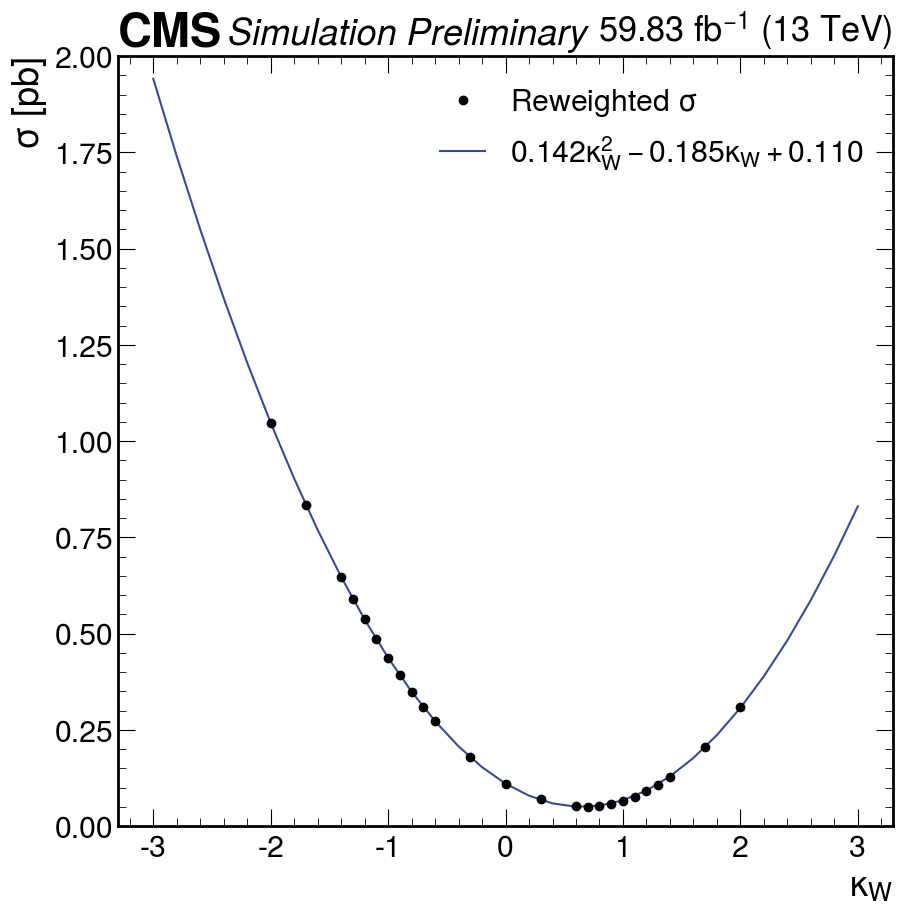

In [7]:
plot_xsecs(kW_eq_1=False)

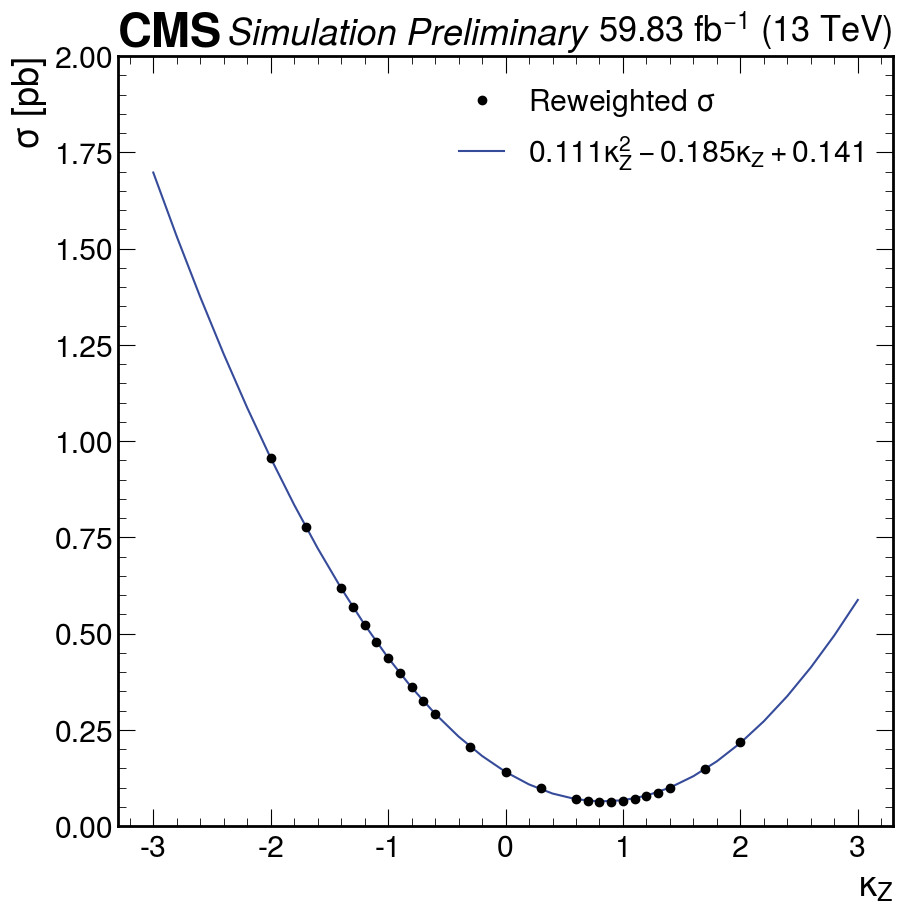

In [8]:
plot_xsecs(kW_eq_1=True)